In [1]:
import requests
import pandas as pd
import time
import sys
import io
##!pip install -U ydata-profiling matplotlib
##!jupyter nbextension enable --py widgetsnbextension
##from ydata_profiling import ProfileReport

#Bases SINAN - Consumindo Base de Dados

In [2]:
bases = [
    {
        "nome": "INFLUD2020",
        "url": "https://s3.sa-east-1.amazonaws.com/ckan.saude.gov.br/SRAG/2020/INFLUD20-01-05-2023.csv"
    },
    {
        "nome": "INFLUD2021",
        "url": "https://s3.sa-east-1.amazonaws.com/ckan.saude.gov.br/SRAG/2021/INFLUD21-01-05-2023.csv"
    },
    {
        "nome": "INFLUD2022",
        "url": "https://s3.sa-east-1.amazonaws.com/ckan.saude.gov.br/SRAG/2022/INFLUD22-03-04-2023.csv"
    },
    {
        "nome": "INFLUD2023",
        "url": "https://s3.sa-east-1.amazonaws.com/ckan.saude.gov.br/SRAG/2023/INFLUD23-01-04-2024.csv"
    },
    {
        "nome": "INFLUD2024",
        "url": "https://s3.sa-east-1.amazonaws.com/ckan.saude.gov.br/SRAG/2024/INFLUD24-01-04-2024.csv"
    },
]

#Pré-Processamento - Limpeza dos Valores Nulos das Colunas.

In [3]:
df = pd.DataFrame()
chunksize = 200000

chunk_total_nulls = {}
total_rows = 0

for base in bases:
  resposta = requests.get(base["url"])
  data = resposta.content

  for chunk in pd.read_csv(io.StringIO(data.decode()), sep=';', chunksize=chunksize):
    chunk_null_sum = chunk.isnull().sum()
    total_rows += len(chunk)

    for column in chunk_null_sum.index:
            chunk_total_nulls[column] = chunk_total_nulls.get(column, 0) + chunk_null_sum[column]

<ipython-input-3-0d6a2f4d01e5>:11: DtypeWarning: Columns (15,59,61,62,63,114,116,117,118,122) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(io.StringIO(data.decode()), sep=';', chunksize=chunksize):
<ipython-input-3-0d6a2f4d01e5>:11: DtypeWarning: Columns (59,61,62,63,91,114,116,117,118,122) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(io.StringIO(data.decode()), sep=';', chunksize=chunksize):
<ipython-input-3-0d6a2f4d01e5>:11: DtypeWarning: Columns (15,59,61,62,63,91,93,114,116,117,118,122) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(io.StringIO(data.decode()), sep=';', chunksize=chunksize):
<ipython-input-3-0d6a2f4d01e5>:11: DtypeWarning: Columns (15,59,61,62,63,91,93,114,116,117,118,122) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(io.StringIO(data.decode()), sep

In [4]:
column_percentages = {}

for column, null_count in chunk_total_nulls.items():
    percentage = (null_count / total_rows) * 100
    column_percentages[column] = percentage

missing_percentage_series = pd.Series(column_percentages)

percent_null = missing_percentage_series[missing_percentage_series > 20]

In [5]:
for base in bases:
  resposta = requests.get(base["url"])
  data = resposta.content

  chunk_list = []

  for chunk in pd.read_csv(io.StringIO(data.decode()), sep=';', chunksize=chunksize):
        # Drop columns with more than 20% missing values
        chunk_dropped = chunk.drop(percent_null.index.intersection(chunk.columns), axis=1)
        chunk_list.append(chunk_dropped)
        df_base = pd.concat(chunk_list, ignore_index=True)
  df = pd.concat([df, df_base], ignore_index=True)

<ipython-input-5-9ecdbacfbca6>:7: DtypeWarning: Columns (15,59,61,62,63,114,116,117,118,122) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(io.StringIO(data.decode()), sep=';', chunksize=chunksize):
<ipython-input-5-9ecdbacfbca6>:7: DtypeWarning: Columns (59,61,62,63,91,114,116,117,118,122) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(io.StringIO(data.decode()), sep=';', chunksize=chunksize):
<ipython-input-5-9ecdbacfbca6>:7: DtypeWarning: Columns (15,59,61,62,63,91,93,114,116,117,118,122) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(io.StringIO(data.decode()), sep=';', chunksize=chunksize):
<ipython-input-5-9ecdbacfbca6>:7: DtypeWarning: Columns (15,59,61,62,63,91,93,114,116,117,118,122) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(io.StringIO(data.decode()), sep=';'

#Pré-Processamento - Limpeza dos Valores Nulos das Linhas

In [6]:
##Limpando as Linhas com % de informações Vazias ou com Coluna Alvo Vazias
df_cleaned = df.dropna(thresh=0.78*df.shape[1]).reset_index(drop=True)
##Limpando Linhas com
df_cleaned = df_cleaned.dropna(subset=['CLASSI_FIN']).reset_index(drop=True)

##Criando uma Nova Feature Relacionando os Dias entre os sintomas iniciais e a notificação.
df_cleaned['DT_NOTIFIC'] = pd.to_datetime(df_cleaned['DT_NOTIFIC'], format='%d/%m/%Y')
df_cleaned['DT_SIN_PRI'] = pd.to_datetime(df_cleaned['DT_SIN_PRI'], format='%d/%m/%Y')

df_cleaned['DIAS_SINTOMA'] = (df_cleaned['DT_NOTIFIC'] - df_cleaned['DT_SIN_PRI']).dt.days

df_cleaned

,DT_NOTIFIC,SEM_NOT,DT_SIN_PRI,SEM_PRI,SG_UF_NOT,ID_REGIONA,CO_REGIONA,ID_MUNICIP,CO_MUN_NOT,ID_UNIDADE,...,REINF,FAB_ADIC,LOT_RE_BI,FAB_RE_BI,DOSE_ADIC,DOS_RE_BI,LOTE_ADIC,TABAG,CASO_SRAG,DIAS_SINTOMA
0,2023-01-03,1,2023-01-03,1,SP,GVE XVII CAMPINAS,1342.0,VINHEDO,355670,SANTA CASA DE VINHEDO,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2023-01-03,1,2023-01-01,1,SP,GVE XXIV RIBEIRAO PRETO,1348.0,RIBEIRAO PRETO,354340,HOSPITAL ESTADUAL DE RIB PRETO DR CARLOS EDUAR...,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2,2023-01-05,1,2023-01-05,1,SP,GVE XVII CAMPINAS,1342.0,CAMPINAS,350950,UNIDADE DE PRONTO ATENDIMENTO ANCHIETA METROPO...,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,2023-01-04,1,2023-01-03,1,SP,GVE XXXI SOROCABA,1353.0,SALTO,354520,HOSPITAL E MATERNIDADE MUNICIPAL N S DO MONTE ...,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,2023-01-02,1,2023-01-02,1,MS,EX ARS DE CAMPO GRANDE,1975.0,CAMPO GRANDE,500270,SANTA CASA,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89946,2024-03-17,12,2024-03-16,11,SP,GVE XXI PRESIDENTE PRUDENTE,1346.0,PRESIDENTE PRUDENTE,354140,SANTA CASA HOSP DR ARISTOTELES OLIVEIRA MARTIN...,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1
89947,2024-03-20,12,2024-03-05,10,SP,GVE XVII CAMPINAS,1342.0,JAGUARIUNA,352470,HOSPITAL MUNICIPAL WALTER FERRARI,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,15
89948,2024-03-20,12,2024-02-28,9,BA,NUCLEO REGIONAL DE SAUDE LESTE,1380.0,SALVADOR,292740,HOSPITAL MARTAGAO GESTEIRA,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,21
89949,2024-03-25,13,2024-03-14,11,SC,CHAPECO,1553.0,CHAPECO,420420,HOSPITAL REGIONAL DO OESTE,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,11


In [7]:
colunas = [
'CS_SEXO',
'NU_IDADE_N',
'CS_GESTANT',
'CS_RACA',
'NOSOCOMIAL',
'AVE_SUINO',
'FEBRE',
'TOSSE',
'DISPNEIA',
'DESC_RESP',
'SATURACAO',
'ANTIVIRAL',
'HOSPITAL',
'UTI',
'SUPORT_VEN',
'CLASSI_FIN',
'ESTRANG',
'VACINA_COV',
'TRAT_COV',
'DIAS_SINTOMA'
]

df_pre = df_cleaned[colunas]

In [8]:
df_pre

,CS_SEXO,NU_IDADE_N,CS_GESTANT,CS_RACA,NOSOCOMIAL,AVE_SUINO,FEBRE,TOSSE,DISPNEIA,DESC_RESP,SATURACAO,ANTIVIRAL,HOSPITAL,UTI,SUPORT_VEN,CLASSI_FIN,ESTRANG,VACINA_COV,TRAT_COV,DIAS_SINTOMA
0,F,61,5,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,3.0,5.0,2.0,1.0,2.0,0
1,M,40,6,1.0,2.0,9.0,2.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,3.0,4.0,2.0,1.0,2.0,2
2,F,90,5,1.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,4.0,2.0,2.0,2.0,0
3,M,12,6,4.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,4.0,2.0,1.0,2.0,1
4,M,24,6,4.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,5.0,2.0,1.0,9.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89946,F,75,6,1.0,1.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,1.0,2.0,3.0,5.0,2.0,2.0,2.0,1
89947,F,4,6,1.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,3.0,4.0,2.0,2.0,2.0,15
89948,F,5,6,9.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0,9.0,1.0,2.0,3.0,4.0,2.0,1.0,NaN,21
89949,F,91,5,1.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,9.0,1.0,2.0,2.0,5.0,2.0,2.0,9.0,11


#Pré-Processamento - Encodando e preparando valores para os Modelos.

In [9]:
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder()

##Encodando as Colunas necessárias.
df_pre["CS_SEXO"] = ord_enc.fit_transform(df_pre[["CS_SEXO"]])

##Enchendo Valores nulls restantes
df_pre.fillna(-999, inplace=True)

##Mudando Resultados do diferentes tipos de "Outros" para um grupo unico.
df_pre.loc[df_pre['CLASSI_FIN'].isin([2.0,3.0,4.0]), 'CLASSI_FIN'] = 2.0

<ipython-input-9-99142f6acbe0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pre["CS_SEXO"] = ord_enc.fit_transform(df_pre[["CS_SEXO"]])
<ipython-input-9-99142f6acbe0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pre.fillna(-999, inplace=True)


In [10]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

df_pre.to_csv('/content/drive/My Drive/Projeto SRAG/srag_nulos.csv', index=False)

Mounted at /content/drive


#Salvando a Base Pre-Processada em CSV
**Rodar Apartir desta Celula afim de agilizar a analise, caso algum erro, favor rodar Todas as celulas anteriores para geração do Arquivo CSV.*

In [11]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

try:
  ##Lendo do Arquivo Salvo
  df_pre = pd.read_csv('/content/drive/My Drive/Projeto SRAG/srag_nulos.csv')
except FileNotFoundError:
  df_pre = pd.DataFrame()
if df_pre.empty:
  print('Falha na Leitura, favor rodar Todas as celulas Anteriores para criação do dataframe')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Balanceamento dos Dados

In [12]:
##Contando os Resultados da Coluna Alvo
pd.Series(df_pre.CLASSI_FIN).value_counts()

CLASSI_FIN
2.0    66949
5.0    18626
1.0     4376
Name: count, dtype: int64

##SMOTE
####Implementação




In [13]:
##Balanceando a Base de Dados
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

##Dropando a Coluna Alvo
X = df_pre.drop('CLASSI_FIN', axis=1)
y = df_pre['CLASSI_FIN']

##Separando a Base em Teste e Treino
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classe_minoria = y_train.value_counts().idxmin()
df_treino = pd.concat([X_train, y_train], axis=1)

df_minoria = df_treino[df_treino['CLASSI_FIN'] == classe_minoria]
qtd_minoria_instancias = len(df_minoria)

df_smote = df_minoria

for classe_maioria in y_train.value_counts().index:
  if classe_maioria != classe_minoria:
    df_maioria = df_treino[df_treino['CLASSI_FIN'] == classe_maioria]
    df_maioria_smote = resample(
        df_maioria,
        replace = False,
        n_samples = qtd_minoria_instancias,
        random_state = 42
    )
    df_smote = pd.concat([df_smote, df_maioria_smote])

#Separando as Features SMOTE
X_treino_smote = df_smote.drop('CLASSI_FIN', axis=1)
y_treino_smote = df_smote['CLASSI_FIN']

#Separando os dados de Teste Balanceados do SMOTE
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_treino_smote, y_treino_smote, test_size=0.2, random_state=42)

##Contagem de Valores da Coluna Alvo, para analisar o Balanceamento.
pd.Series(y_treino_smote).value_counts()

CLASSI_FIN
1.0    3470
2.0    3470
5.0    3470
Name: count, dtype: int64

###SMOTE - Feature Selection SFS - Random Forest
Com a Base Limpa dos nulos e colunas desnecessárias, iremos realizar uma feature selection afim de definir quais são as de maior peso.


In [14]:
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

sfs_rf = SFS(rf_classifier,
          k_features='best',
          forward = True,
          floating = False,
          verbose = 2,
          scoring = 'accuracy',
          cv = 5)

sfs_rf = sfs_rf.fit(X_train_smote, y_train_smote)

features_selecionadas = list(sfs_rf.k_feature_idx_)


[2024-06-09 17:52:52] Features: 1/19 -- score: 0.48811286676832893
[2024-06-09 17:53:34] Features: 2/19 -- score: 0.5260569092501866
[2024-06-09 17:54:16] Features: 3/19 -- score: 0.5260568371492742
[2024-06-09 17:54:58] Features: 4/19 -- score: 0.5242559726593339
[2024-06-09 17:55:40] Features: 5/19 -- score: 0.52065294586303
[2024-06-09 17:56:19] Features: 6/19 -- score: 0.515970207902981
[2024-06-09 17:57:01] Features: 7/19 -- score: 0.5100861245399061
[2024-06-09 17:57:41] Features: 8/19 -- score: 0.509486605452992
[2024-06-09 17:58:20] Features: 9/19 -- score: 0.506125116713352
[2024-06-09 17:58:58] Features: 10/19 -- score: 0.505164804660603
[2024-06-09 17:59:33] Features: 11/19 -- score: 0.49964245157522474
[2024-06-09 18:00:09] Features: 12/19 -- score: 0.5019238686465577
[2024-06-09 18:00:39] Features: 13/19 -- score: 0.49735995299020513
[2024-06-09 18:01:05] Features: 14/19 -- score: 0.5014405041295797
[2024-06-09 18:01:26] Features: 15/19 -- score: 0.5111660520063881
[2024-

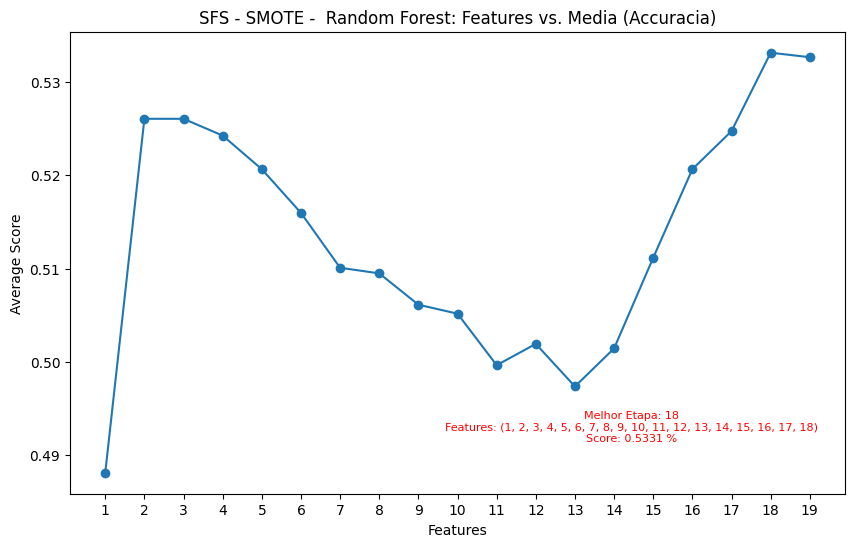

In [15]:
import matplotlib.pyplot as plt

feature_names = X_train_smote.columns
steps = []
scores = []
selected_features = []

best_score = 0

for k in sfs_rf.subsets_:
    avg_score = sfs_rf.subsets_[k]['avg_score']
    features = [feature_names[i] for i in sfs_rf.subsets_[k]['feature_idx']]

    steps.append(k)
    scores.append(avg_score)
    selected_features.append(features)

    if avg_score > best_score:
        best_score = avg_score
        best_step = k
        best_features = sfs_rf.subsets_[k]['feature_idx']

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(steps, scores, marker='o')
plt.xlabel('Features')
plt.ylabel('Average Score')
plt.title('SFS - SMOTE -  Random Forest: Features vs. Media (Accuracia)')

# Setting x-axis to show only integer values
plt.xticks(range(min(steps), max(steps) + 1, 1))

# Annotate only the best step
plt.annotate(f"Melhor Etapa: {best_step}\nFeatures: {best_features}\nScore: {best_score:.4f} %",
             (best_step, best_score), textcoords="offset points",
             xytext=(-100,-280), ha='center', fontsize=8, color='red')


plt.show()


In [16]:
import joblib

model_filename = '/content/drive/My Drive/Projeto SRAG/sfs_rf_model.pkl'
joblib.dump(sfs_rf, model_filename)

['/content/drive/My Drive/Projeto SRAG/sfs_rf_model.pkl']

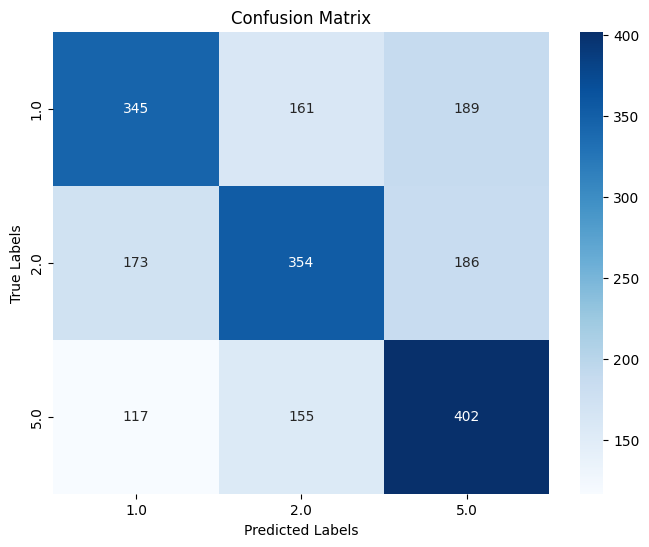

Accuracy: 0.5288184438040345
Confusion Matrix:
[[345 161 189]
 [173 354 186]
 [117 155 402]]
Classification Report:
              precision    recall  f1-score   support

         1.0       0.54      0.50      0.52       695
         2.0       0.53      0.50      0.51       713
         5.0       0.52      0.60      0.55       674

    accuracy                           0.53      2082
   macro avg       0.53      0.53      0.53      2082
weighted avg       0.53      0.53      0.53      2082



In [17]:
from google.colab import drive
import joblib
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

loaded_sfs = joblib.load(model_filename)

# Optionally, get the selected features from the loaded model
loaded_features_selecionadas = list(loaded_sfs.k_feature_idx_)

# Use the selected features to transform the training and test data
X_train_selected = X_train_smote.iloc[:, loaded_features_selecionadas]
X_test_selected = X_test_smote.iloc[:, loaded_features_selecionadas]

# Fit the Random Forest classifier on the selected features of the training data
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_selected, y_train_smote)

# Make predictions on the test data
y_pred = rf_classifier.predict(X_test_selected)

# Evaluate the model
accuracy = accuracy_score(y_test_smote, y_pred)
conf_matrix = confusion_matrix(y_test_smote, y_pred)
class_report = classification_report(y_test_smote, y_pred, output_dict=True)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=rf_classifier.classes_, yticklabels=rf_classifier.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Convert classification report to DataFrame for plotting
report_df = pd.DataFrame(class_report).transpose()

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_report(y_test_smote, y_pred))


###SMOTE - SFS - Naive Bayes (DEV)

In [18]:
from sklearn.naive_bayes import GaussianNB
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Initialize the Naive Bayes classifier
nb_classifier = GaussianNB()

# Initialize the Sequential Feature Selector with Naive Bayes
sfs_nb = SFS(nb_classifier,
          k_features='best',
          forward=True,
          floating=False,
          verbose=2,
          scoring='accuracy',
          cv=5)

# Fit the SFS on the training data
sfs_nb = sfs_nb.fit(X_train_smote, y_train_smote)

# Get the selected features
features_selecionadas = list(sfs_nb.k_feature_idx_)

# Optionally, print the selected features
print("\nSelected features:", features_selecionadas)



[2024-06-09 18:02:21] Features: 1/19 -- score: 0.4860707526253745
[2024-06-09 18:02:21] Features: 2/19 -- score: 0.49471687774208783
[2024-06-09 18:02:22] Features: 3/19 -- score: 0.49483815147680693
[2024-06-09 18:02:22] Features: 4/19 -- score: 0.4937564214875139
[2024-06-09 18:02:23] Features: 5/19 -- score: 0.49111478825764543
[2024-06-09 18:02:23] Features: 6/19 -- score: 0.48547152194211013
[2024-06-09 18:02:23] Features: 7/19 -- score: 0.47778852081373097
[2024-06-09 18:02:24] Features: 8/19 -- score: 0.46722148318786977
[2024-06-09 18:02:24] Features: 9/19 -- score: 0.45473454246563494
[2024-06-09 18:02:24] Features: 10/19 -- score: 0.44320690438337496
[2024-06-09 18:02:24] Features: 11/19 -- score: 0.42879703232644417
[2024-06-09 18:02:25] Features: 12/19 -- score: 0.40285887327904135
[2024-06-09 18:02:25] Features: 13/19 -- score: 0.3848485700586541
[2024-06-09 18:02:25] Features: 14/19 -- score: 0.3820876819196147
[2024-06-09 18:02:25] Features: 15/19 -- score: 0.3850893871


Selected features: [1, 6, 16]



[2024-06-09 18:02:25] Features: 17/19 -- score: 0.3843680174772611
[2024-06-09 18:02:26] Features: 18/19 -- score: 0.37560184434134014
[2024-06-09 18:02:26] Features: 19/19 -- score: 0.3637133411923328

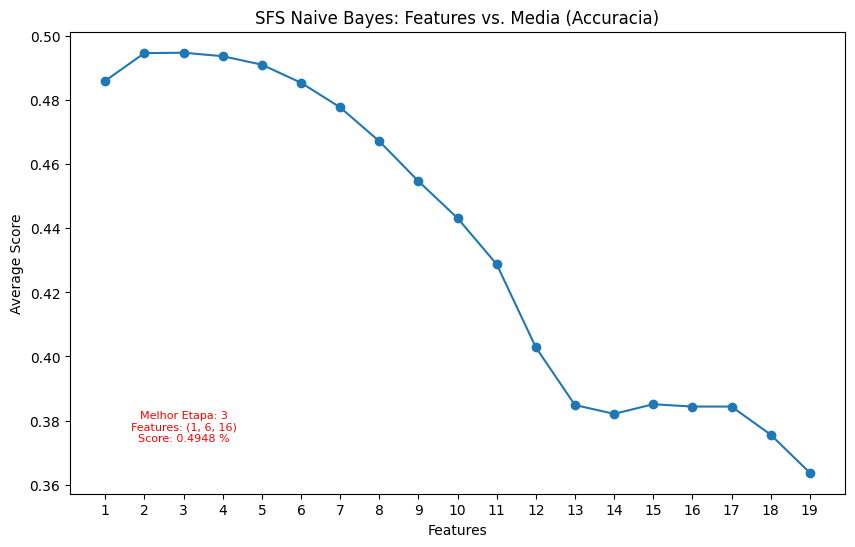

In [19]:
import matplotlib.pyplot as plt

feature_names = X_train_smote.columns
steps = []
scores = []
selected_features = []

best_score = 0

for k in sfs_nb.subsets_:
    avg_score = sfs_nb.subsets_[k]['avg_score']
    features = [feature_names[i] for i in sfs_nb.subsets_[k]['feature_idx']]

    steps.append(k)
    scores.append(avg_score)
    selected_features.append(features)

    if avg_score > best_score:
        best_score = avg_score
        best_step = k
        best_features = sfs_nb.subsets_[k]['feature_idx']

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(steps, scores, marker='o')
plt.xlabel('Features')
plt.ylabel('Average Score')
plt.title('SFS Naive Bayes: Features vs. Media (Accuracia)')

# Setting x-axis to show only integer values
plt.xticks(range(min(steps), max(steps) + 1, 1))

# Annotate only the best step
plt.annotate(f"Melhor Etapa: {best_step}\nFeatures: {best_features}\nScore: {best_score:.4f} %",
             (best_step, best_score), textcoords="offset points",
             xytext=(0, -280), ha='center', fontsize=8, color='red')

plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


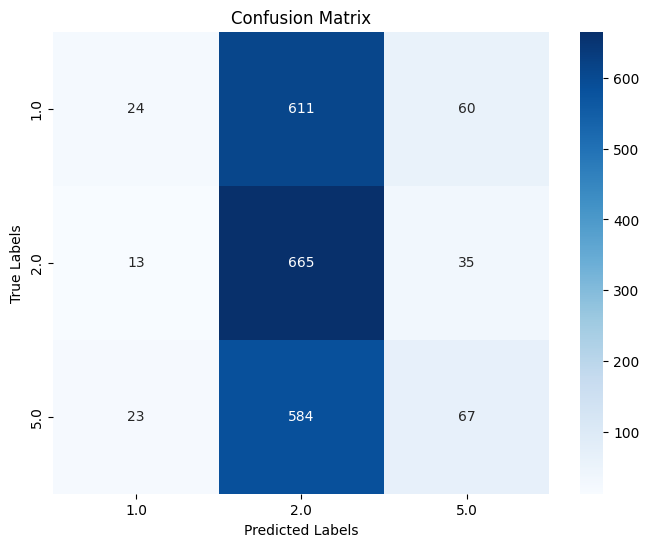

Accuracy: 0.3631123919308357
Confusion Matrix:
[[ 24 611  60]
 [ 13 665  35]
 [ 23 584  67]]
Classification Report:
              precision    recall  f1-score   support

         1.0       0.40      0.03      0.06       695
         2.0       0.36      0.93      0.52       713
         5.0       0.41      0.10      0.16       674

    accuracy                           0.36      2082
   macro avg       0.39      0.36      0.25      2082
weighted avg       0.39      0.36      0.25      2082



In [20]:
from google.colab import drive
import joblib
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Path to the model file in Google Drive
model_filename = '/content/drive/My Drive/Projeto SRAG/sfs_nb_model.pkl'

# Load the model from the file
loaded_sfs = joblib.load(model_filename)
#print("Loaded model:", loaded_sfs)

# Optionally, get the selected features from the loaded model
loaded_features_selecionadas = list(loaded_sfs.k_feature_idx_)
#print("Loaded selected features:", loaded_features_selecionadas)

# Use the selected features to transform the training and test data
X_train_selected = X_train_smote.iloc[:, loaded_features_selecionadas]
X_test_selected = X_test_smote.iloc[:, loaded_features_selecionadas]

# Fit the Naive Bayes classifier on the selected features of the training data
nb_classifier = GaussianNB()
nb_classifier.fit(X_train_selected, y_train_smote)

# Make predictions on the test data
y_pred = nb_classifier.predict(X_test_selected)

# Evaluate the model
accuracy = accuracy_score(y_test_smote, y_pred)
conf_matrix = confusion_matrix(y_test_smote, y_pred)
class_report = classification_report(y_test_smote, y_pred, output_dict=True)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=nb_classifier.classes_, yticklabels=nb_classifier.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Convert classification report to DataFrame for plotting
report_df = pd.DataFrame(class_report).transpose()

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_report(y_test_smote, y_pred))


In [21]:
import joblib

model_filename = '/content/drive/My Drive/Projeto SRAG/sfs_nb_model.pkl'
joblib.dump(sfs_rf, model_filename)

['/content/drive/My Drive/Projeto SRAG/sfs_nb_model.pkl']

###SMOTE - SFS - K-NN (DEV)

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Initialize the k-Nearest Neighbors classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)

# Initialize the Sequential Feature Selector with k-NN
sfs_knn = SFS(knn_classifier,
          k_features='best',
          forward=True,
          floating=False,
          verbose=2,
          scoring='accuracy',
          cv=5)

# Fit the SFS on the training data
sfs_knn = sfs_knn.fit(X_train_smote, y_train_smote)

# Get the selected features
features_selecionadas = list(sfs_knn.k_feature_idx_)

# Optionally, print the selected features
print("\nSelected features:", features_selecionadas)



[2024-06-09 18:02:43] Features: 1/19 -- score: 0.4127012967349102
[2024-06-09 18:02:53] Features: 2/19 -- score: 0.44368421242370826
[2024-06-09 18:03:04] Features: 3/19 -- score: 0.457852546423975
[2024-06-09 18:03:14] Features: 4/19 -- score: 0.4636164375660174
[2024-06-09 18:03:29] Features: 5/19 -- score: 0.4652991286604732
[2024-06-09 18:03:41] Features: 6/19 -- score: 0.4695013140391292
[2024-06-09 18:03:55] Features: 7/19 -- score: 0.46962143415924934
[2024-06-09 18:04:09] Features: 8/19 -- score: 0.46878246794213185
[2024-06-09 18:04:23] Features: 9/19 -- score: 0.4696234529847976
[2024-06-09 18:04:37] Features: 10/19 -- score: 0.46854244400462886
[2024-06-09 18:04:51] Features: 11/19 -- score: 0.46602093089488045
[2024-06-09 18:05:03] Features: 12/19 -- score: 0.4626598747607151
[2024-06-09 18:05:15] Features: 13/19 -- score: 0.4610980247955038
[2024-06-09 18:05:27] Features: 14/19 -- score: 0.4648189365836425
[2024-06-09 18:05:37] Features: 15/19 -- score: 0.4637375670989116


Selected features: [0, 1, 4, 6, 7, 11, 12, 15, 16]



[2024-06-09 18:05:44] Features: 19/19 -- score: 0.44440637516267767

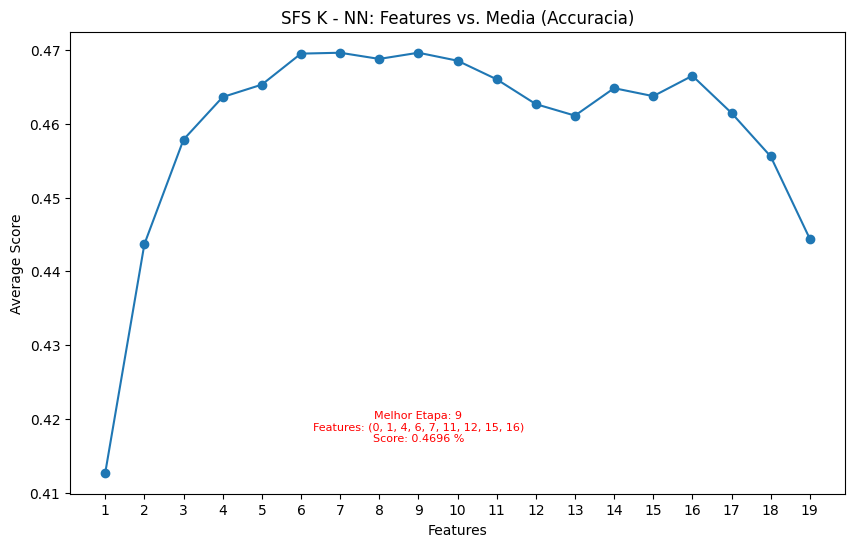

In [23]:
feature_names = X_train_smote.columns
steps = []
scores = []
selected_features = []

best_score = 0

for k in sfs_knn.subsets_:
    avg_score = sfs_knn.subsets_[k]['avg_score']
    features = [feature_names[i] for i in sfs_knn.subsets_[k]['feature_idx']]

    steps.append(k)
    scores.append(avg_score)
    selected_features.append(features)

    if avg_score > best_score:
        best_score = avg_score
        best_step = k
        best_features = sfs_knn.subsets_[k]['feature_idx']

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(steps, scores, marker='o')
plt.xlabel('Features')
plt.ylabel('Average Score')
plt.title('SFS K - NN: Features vs. Media (Accuracia)')

# Setting x-axis to show only integer values
plt.xticks(range(min(steps), max(steps) + 1, 1))

# Annotate only the best step
plt.annotate(f"Melhor Etapa: {best_step}\nFeatures: {best_features}\nScore: {best_score:.4f} %",
             (best_step, best_score), textcoords="offset points",
             xytext=(0,-280), ha='center', fontsize=8, color='red')


plt.show()

In [24]:
import joblib

model_filename = '/content/drive/My Drive/Projeto SRAG/sfs_knn_model.pkl'
joblib.dump(sfs_rf, model_filename)

['/content/drive/My Drive/Projeto SRAG/sfs_knn_model.pkl']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


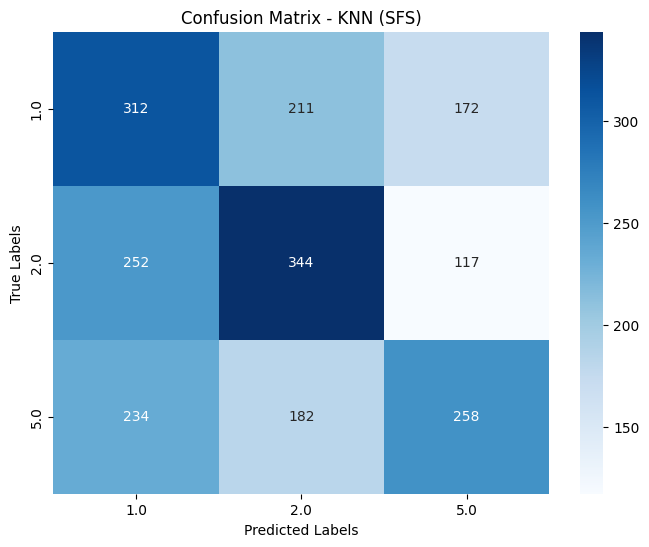

Accuracy: 0.4390009606147935
Confusion Matrix:
[[312 211 172]
 [252 344 117]
 [234 182 258]]
Classification Report:
              precision    recall  f1-score   support

         1.0       0.39      0.45      0.42       695
         2.0       0.47      0.48      0.47       713
         5.0       0.47      0.38      0.42       674

    accuracy                           0.44      2082
   macro avg       0.44      0.44      0.44      2082
weighted avg       0.44      0.44      0.44      2082



In [25]:
from google.colab import drive
import joblib
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Path to the model file in Google Drive
model_filename = '/content/drive/My Drive/Projeto SRAG/sfs_knn_model.pkl'

# Load the model from the file
loaded_sfs = joblib.load(model_filename)
#print("Loaded model:", loaded_sfs)

# Optionally, get the selected features from the loaded model
loaded_features_selecionadas = list(loaded_sfs.k_feature_idx_)
#print("Loaded selected features:", loaded_features_selecionadas)

# Use the selected features to transform the training and test data
X_train_selected = X_train_smote.iloc[:, loaded_features_selecionadas]
X_test_selected = X_test_smote.iloc[:, loaded_features_selecionadas]

# Fit the Naive Bayes classifier on the selected features of the training data
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train_selected, y_train_smote)

# Make predictions on the test data
y_pred = knn_classifier.predict(X_test_selected)

# Evaluate the model
accuracy = accuracy_score(y_test_smote, y_pred)
conf_matrix = confusion_matrix(y_test_smote, y_pred)
class_report = classification_report(y_test_smote, y_pred, output_dict=True)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=knn_classifier.classes_, yticklabels=knn_classifier.classes_)
plt.title('Confusion Matrix - KNN (SFS)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Convert classification report to DataFrame for plotting
report_df = pd.DataFrame(class_report).transpose()

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_report(y_test_smote, y_pred))


##Undersampling
####Implementação


In [26]:
from sklearn.utils import resample

#Separando os DataFrames em Maioria e Minoria
df_minoria = df_pre[df_pre['CLASSI_FIN'] == 1.0]

df_maioria1 = df_pre[df_pre['CLASSI_FIN'] == 5.0]

df_maioria2 = df_pre[df_pre['CLASSI_FIN'] == 2.0]

df_maioria1_undersample = resample(
    df_maioria1,
    replace = False,
    n_samples = len(df_minoria),
    random_state = 42
)

df_maioria2_undersample = resample(
    df_maioria2,
    replace = False,
    n_samples = len(df_minoria),
    random_state = 42
)

df_undersample = pd.concat([df_maioria1_undersample, df_maioria2_undersample, df_minoria])

df_undersample['CLASSI_FIN'].value_counts()

CLASSI_FIN
5.0    4376
2.0    4376
1.0    4376
Name: count, dtype: int64

###Undersampling - SFS - Random Forest

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import train_test_split

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

##Dropando a Coluna Alvo
X_undersample = df_undersample.drop('CLASSI_FIN', axis=1)
y_undersample = df_undersample['CLASSI_FIN']

##Separando a Base em Teste e Treino
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(X_undersample, y_undersample, test_size=0.2, random_state=42)

sfs_rf_undersample = SFS(rf_classifier,
          k_features='best',
          forward = True,
          floating = False,
          verbose = 2,
          scoring = 'accuracy',
          cv = 5)

sfs_rf_undersample = sfs_rf_undersample.fit(X_train_undersample, y_train_undersample)

features_selecionadas = list(sfs_rf_undersample.k_feature_idx_)


[2024-06-09 18:06:18] Features: 1/19 -- score: 0.49876263004011695
[2024-06-09 18:07:07] Features: 2/19 -- score: 0.5412313864146325
[2024-06-09 18:07:56] Features: 3/19 -- score: 0.5414218172752203
[2024-06-09 18:08:46] Features: 4/19 -- score: 0.5372316130640737
[2024-06-09 18:09:33] Features: 5/19 -- score: 0.5339947417329617
[2024-06-09 18:10:24] Features: 6/19 -- score: 0.5317090274472474
[2024-06-09 18:11:11] Features: 7/19 -- score: 0.5295194125246481
[2024-06-09 18:11:59] Features: 8/19 -- score: 0.5232356927540174
[2024-06-09 18:12:48] Features: 9/19 -- score: 0.5181879377167335
[2024-06-09 18:13:36] Features: 10/19 -- score: 0.5113326533850093
[2024-06-09 18:14:21] Features: 11/19 -- score: 0.511808163912876
[2024-06-09 18:15:03] Features: 12/19 -- score: 0.5069524716121575
[2024-06-09 18:15:39] Features: 13/19 -- score: 0.5075239908433625
[2024-06-09 18:16:18] Features: 14/19 -- score: 0.5187582330409556
[2024-06-09 18:16:50] Features: 15/19 -- score: 0.5253286643548424
[20

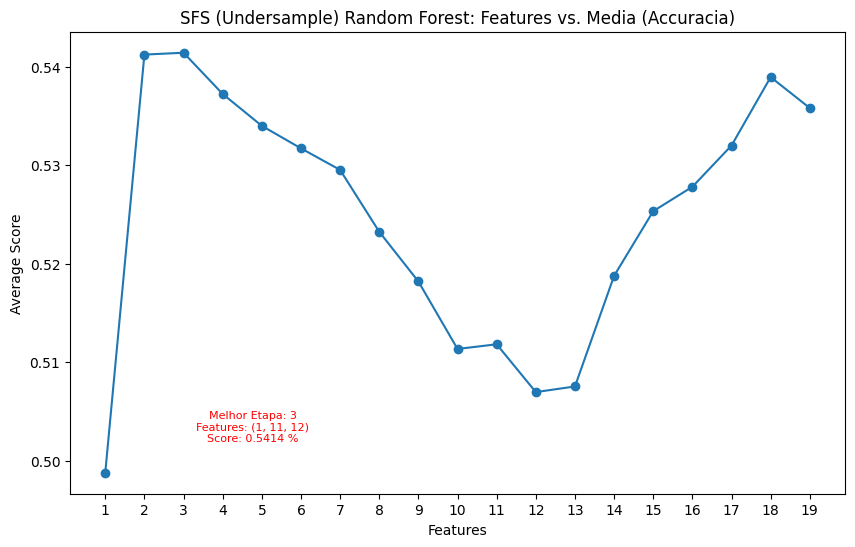

In [28]:
import matplotlib.pyplot as plt

feature_names = X_train_undersample.columns
steps = []
scores = []
selected_features = []

best_score = 0

for k in sfs_rf_undersample.subsets_:
    avg_score = sfs_rf_undersample.subsets_[k]['avg_score']
    features = [feature_names[i] for i in sfs_rf_undersample.subsets_[k]['feature_idx']]

    steps.append(k)
    scores.append(avg_score)
    selected_features.append(features)

    if avg_score > best_score:
        best_score = avg_score
        best_step = k
        best_features = sfs_rf_undersample.subsets_[k]['feature_idx']

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(steps, scores, marker='o')
plt.xlabel('Features')
plt.ylabel('Average Score')
plt.title('SFS (Undersample) Random Forest: Features vs. Media (Accuracia)')

# Setting x-axis to show only integer values
plt.xticks(range(min(steps), max(steps) + 1, 1))

# Annotate only the best step
plt.annotate(f"Melhor Etapa: {best_step}\nFeatures: {best_features}\nScore: {best_score:.4f} %",
             (best_step, best_score), textcoords="offset points",
             xytext=(50,-280), ha='center', fontsize=8, color='red')


plt.show()

In [29]:
import joblib

model_filename = '/content/drive/My Drive/Projeto SRAG/sfs_rf_undersample_model.pkl'
joblib.dump(sfs_rf_undersample, model_filename)

['/content/drive/My Drive/Projeto SRAG/sfs_rf_undersample_model.pkl']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


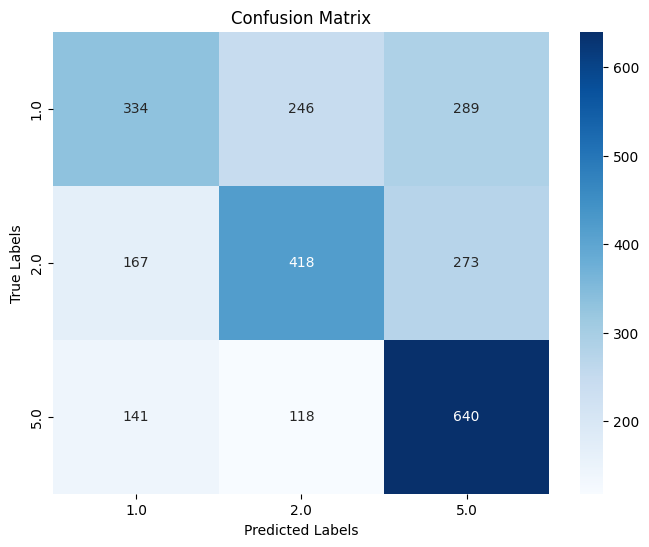

Accuracy: 0.5300837776085301
Confusion Matrix:
[[334 246 289]
 [167 418 273]
 [141 118 640]]
Classification Report:
              precision    recall  f1-score   support

         1.0       0.52      0.38      0.44       869
         2.0       0.53      0.49      0.51       858
         5.0       0.53      0.71      0.61       899

    accuracy                           0.53      2626
   macro avg       0.53      0.53      0.52      2626
weighted avg       0.53      0.53      0.52      2626



In [30]:
from google.colab import drive
import joblib
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Path to the model file in Google Drive
model_filename = '/content/drive/My Drive/Projeto SRAG/sfs_rf_undersample_model.pkl'

# Load the model from the file
loaded_sfs = joblib.load(model_filename)
#print("Loaded model:", loaded_sfs)

# Optionally, get the selected features from the loaded model
loaded_features_selecionadas = list(loaded_sfs.k_feature_idx_)

# Use the selected features to transform the training and test data
X_train_selected = X_train_undersample.iloc[:, loaded_features_selecionadas]
X_test_selected = X_test_undersample.iloc[:, loaded_features_selecionadas]

# Fit the Random Forest classifier on the selected features of the training data
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_selected, y_train_undersample)

# Make predictions on the test data
y_pred = rf_classifier.predict(X_test_selected)

# Evaluate the model
accuracy = accuracy_score(y_test_undersample, y_pred)
conf_matrix = confusion_matrix(y_test_undersample, y_pred)
class_report = classification_report(y_test_undersample, y_pred, output_dict=True)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=rf_classifier.classes_, yticklabels=rf_classifier.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Convert classification report to DataFrame for plotting
report_df = pd.DataFrame(class_report).transpose()

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_report(y_test_undersample, y_pred))

###Undersampling - SFS - Naive Bayes

In [31]:
from sklearn.naive_bayes import GaussianNB
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Initialize the Naive Bayes classifier
nb_classifier = GaussianNB()

# Initialize the Sequential Feature Selector with Naive Bayes
sfs_nb = SFS(nb_classifier,
          k_features='best',
          forward=True,
          floating=False,
          verbose=2,
          scoring='accuracy',
          cv=5)

# Fit the SFS on the training data
sfs_nb_undersample = sfs_nb.fit(X_train_undersample, y_train_undersample)

# Get the selected features
features_selecionadas = list(sfs_nb_undersample.k_feature_idx_)

# Optionally, print the selected features
print("\nSelected features:", features_selecionadas)


[2024-06-09 18:17:58] Features: 1/19 -- score: 0.49609523809523814
[2024-06-09 18:17:58] Features: 2/19 -- score: 0.4948577774755785
[2024-06-09 18:17:58] Features: 3/19 -- score: 0.5001901135513701
[2024-06-09 18:17:59] Features: 4/19 -- score: 0.5000002719793295
[2024-06-09 18:17:59] Features: 5/19 -- score: 0.49304848031549603
[2024-06-09 18:18:00] Features: 6/19 -- score: 0.4877176854559053
[2024-06-09 18:18:00] Features: 7/19 -- score: 0.48067002107839796
[2024-06-09 18:18:01] Features: 8/19 -- score: 0.4622923324494005
[2024-06-09 18:18:01] Features: 9/19 -- score: 0.43353554996486937
[2024-06-09 18:18:01] Features: 10/19 -- score: 0.3944950930395956
[2024-06-09 18:18:02] Features: 11/19 -- score: 0.3998284717028172
[2024-06-09 18:18:02] Features: 12/19 -- score: 0.40154089889168426
[2024-06-09 18:18:02] Features: 13/19 -- score: 0.3981121461435598
[2024-06-09 18:18:02] Features: 14/19 -- score: 0.39592262188073707
[2024-06-09 18:18:03] Features: 15/19 -- score: 0.38535423041182


Selected features: [1, 16, 18]



[2024-06-09 18:18:03] Features: 18/19 -- score: 0.36592973867319417
[2024-06-09 18:18:03] Features: 19/19 -- score: 0.36545382017633327

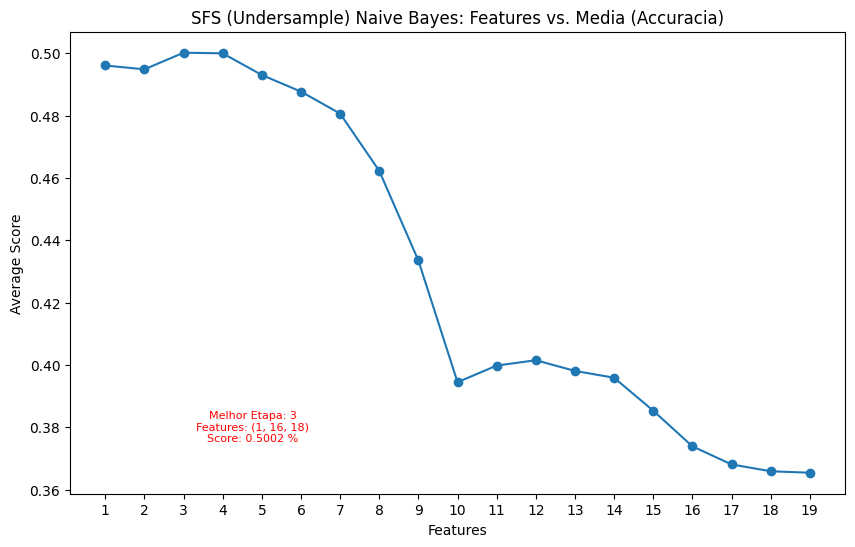

In [32]:
import matplotlib.pyplot as plt

feature_names = X_train_undersample.columns
steps = []
scores = []
selected_features = []

best_score = 0

for k in sfs_nb_undersample.subsets_:
    avg_score = sfs_nb_undersample.subsets_[k]['avg_score']
    features = [feature_names[i] for i in sfs_nb_undersample.subsets_[k]['feature_idx']]

    steps.append(k)
    scores.append(avg_score)
    selected_features.append(features)

    if avg_score > best_score:
        best_score = avg_score
        best_step = k
        best_features = sfs_nb_undersample.subsets_[k]['feature_idx']

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(steps, scores, marker='o')
plt.xlabel('Features')
plt.ylabel('Average Score')
plt.title('SFS (Undersample) Naive Bayes: Features vs. Media (Accuracia)')

# Setting x-axis to show only integer values
plt.xticks(range(min(steps), max(steps) + 1, 1))

# Annotate only the best step
plt.annotate(f"Melhor Etapa: {best_step}\nFeatures: {best_features}\nScore: {best_score:.4f} %",
             (best_step, best_score), textcoords="offset points",
             xytext=(50,-280), ha='center', fontsize=8, color='red')


plt.show()

In [33]:
import joblib

model_filename = '/content/drive/My Drive/Projeto SRAG/sfs_nb_undersample_model.pkl'
joblib.dump(sfs_nb_undersample, model_filename)

['/content/drive/My Drive/Projeto SRAG/sfs_nb_undersample_model.pkl']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


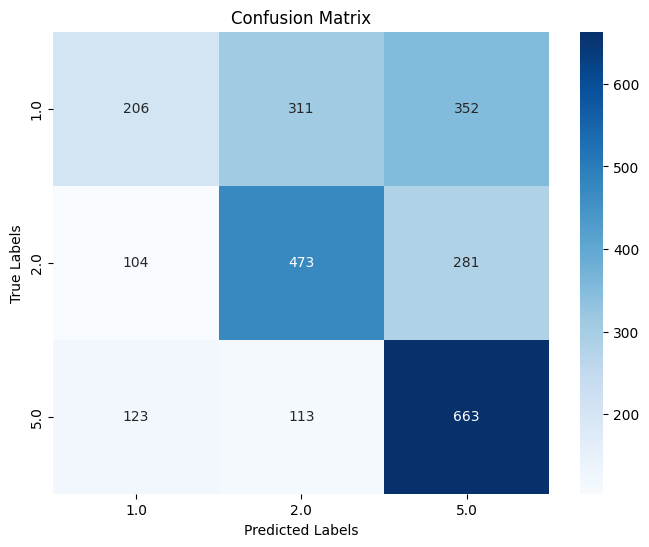

Accuracy: 0.511043412033511
Confusion Matrix:
[[206 311 352]
 [104 473 281]
 [123 113 663]]
Classification Report:
              precision    recall  f1-score   support

         1.0       0.48      0.24      0.32       869
         2.0       0.53      0.55      0.54       858
         5.0       0.51      0.74      0.60       899

    accuracy                           0.51      2626
   macro avg       0.50      0.51      0.49      2626
weighted avg       0.50      0.51      0.49      2626



In [34]:
from google.colab import drive
import joblib
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.naive_bayes import GaussianNB
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Path to the model file in Google Drive
model_filename = '/content/drive/My Drive/Projeto SRAG/sfs_nb_undersample_model.pkl'

# Load the model from the file
loaded_sfs = joblib.load(model_filename)
#print("Loaded model:", loaded_sfs)

# Optionally, get the selected features from the loaded model
loaded_features_selecionadas = list(loaded_sfs.k_feature_idx_)

# Use the selected features to transform the training and test data
X_train_selected = X_train_undersample.iloc[:, loaded_features_selecionadas]
X_test_selected = X_test_undersample.iloc[:, loaded_features_selecionadas]

# Fit the Naive Bayes classifier on the selected features of the training data
nb_classifier = GaussianNB()
nb_classifier.fit(X_train_selected, y_train_undersample)

# Make predictions on the test data
y_pred = nb_classifier.predict(X_test_selected)

# Evaluate the model
accuracy = accuracy_score(y_test_undersample, y_pred)
conf_matrix = confusion_matrix(y_test_undersample, y_pred)
class_report = classification_report(y_test_undersample, y_pred, output_dict=True)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=nb_classifier.classes_, yticklabels=nb_classifier.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Convert classification report to DataFrame for plotting
report_df = pd.DataFrame(class_report).transpose()

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_report(y_test_undersample, y_pred))

###Undersampling - SFS - K-NN

In [35]:
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Initialize the k-Nearest Neighbors classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)

# Initialize the Sequential Feature Selector with k-NN
sfs_knn_undersample = SFS(knn_classifier,
          k_features='best',
          forward=True,
          floating=False,
          verbose=2,
          scoring='accuracy',
          cv=5)

# Fit the SFS on the training data
sfs_knn_undersample = sfs_knn_undersample.fit(X_train_smote, y_train_smote)

# Get the selected features
features_selecionadas = list(sfs_knn_undersample.k_feature_idx_)

# Optionally, print the selected features
print("\nSelected features:", features_selecionadas)



[2024-06-09 18:18:20] Features: 1/19 -- score: 0.4127012967349102
[2024-06-09 18:18:30] Features: 2/19 -- score: 0.44368421242370826
[2024-06-09 18:18:41] Features: 3/19 -- score: 0.457852546423975
[2024-06-09 18:18:51] Features: 4/19 -- score: 0.4636164375660174
[2024-06-09 18:19:04] Features: 5/19 -- score: 0.4652991286604732
[2024-06-09 18:19:17] Features: 6/19 -- score: 0.4695013140391292
[2024-06-09 18:19:31] Features: 7/19 -- score: 0.46962143415924934
[2024-06-09 18:19:44] Features: 8/19 -- score: 0.46878246794213185
[2024-06-09 18:20:00] Features: 9/19 -- score: 0.4696234529847976
[2024-06-09 18:20:15] Features: 10/19 -- score: 0.46854244400462886
[2024-06-09 18:20:29] Features: 11/19 -- score: 0.46602093089488045
[2024-06-09 18:20:42] Features: 12/19 -- score: 0.4626598747607151
[2024-06-09 18:20:53] Features: 13/19 -- score: 0.4610980247955038
[2024-06-09 18:21:04] Features: 14/19 -- score: 0.4648189365836425
[2024-06-09 18:21:15] Features: 15/19 -- score: 0.4637375670989116


Selected features: [0, 1, 4, 6, 7, 11, 12, 15, 16]



[2024-06-09 18:21:23] Features: 19/19 -- score: 0.44440637516267767

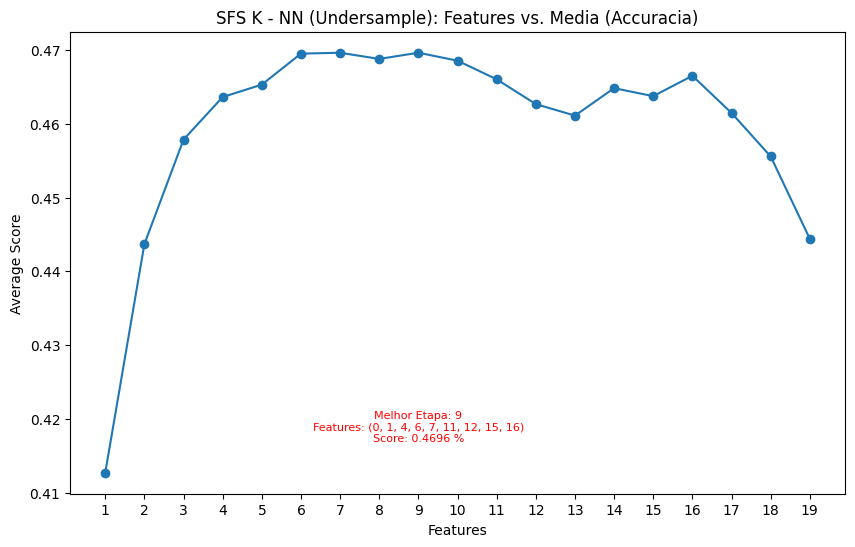

In [36]:
feature_names = X_train_undersample.columns
steps = []
scores = []
selected_features = []

best_score = 0

for k in sfs_knn_undersample.subsets_:
    avg_score = sfs_knn_undersample.subsets_[k]['avg_score']
    features = [feature_names[i] for i in sfs_knn_undersample.subsets_[k]['feature_idx']]

    steps.append(k)
    scores.append(avg_score)
    selected_features.append(features)

    if avg_score > best_score:
        best_score = avg_score
        best_step = k
        best_features = sfs_knn_undersample.subsets_[k]['feature_idx']

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(steps, scores, marker='o')
plt.xlabel('Features')
plt.ylabel('Average Score')
plt.title('SFS K - NN (Undersample): Features vs. Media (Accuracia)')

# Setting x-axis to show only integer values
plt.xticks(range(min(steps), max(steps) + 1, 1))

# Annotate only the best step
plt.annotate(f"Melhor Etapa: {best_step}\nFeatures: {best_features}\nScore: {best_score:.4f} %",
             (best_step, best_score), textcoords="offset points",
             xytext=(0,-280), ha='center', fontsize=8, color='red')


plt.show()

In [37]:
import joblib

model_filename = '/content/drive/My Drive/Projeto SRAG/sfs_knn_undersample_model.pkl'
joblib.dump(sfs_knn_undersample, model_filename)

['/content/drive/My Drive/Projeto SRAG/sfs_knn_undersample_model.pkl']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


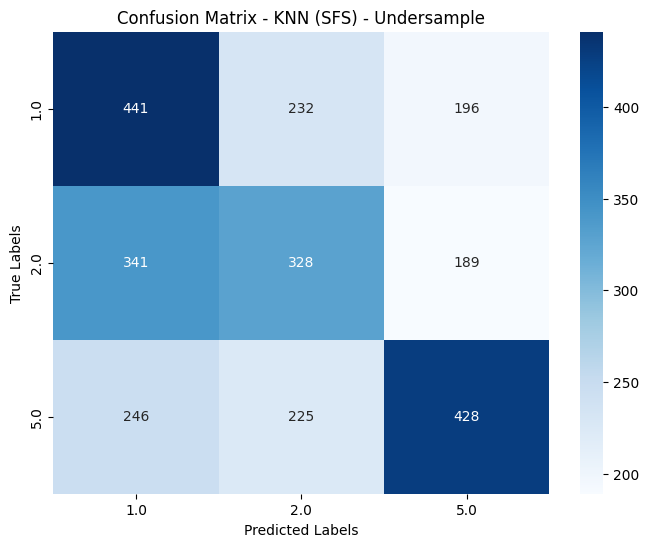

Accuracy: 0.4558263518659558
Confusion Matrix:
[[441 232 196]
 [341 328 189]
 [246 225 428]]
Classification Report:
              precision    recall  f1-score   support

         1.0       0.43      0.51      0.46       869
         2.0       0.42      0.38      0.40       858
         5.0       0.53      0.48      0.50       899

    accuracy                           0.46      2626
   macro avg       0.46      0.46      0.45      2626
weighted avg       0.46      0.46      0.46      2626



In [38]:
from google.colab import drive
import joblib
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Path to the model file in Google Drive
model_filename = '/content/drive/My Drive/Projeto SRAG/sfs_knn_undersample_model.pkl'

# Load the model from the file
loaded_sfs = joblib.load(model_filename)
#print("Loaded model:", loaded_sfs)

# Optionally, get the selected features from the loaded model
loaded_features_selecionadas = list(loaded_sfs.k_feature_idx_)
#print("Loaded selected features:", loaded_features_selecionadas)

# Use the selected features to transform the training and test data
X_train_selected = X_train_undersample.iloc[:, loaded_features_selecionadas]
X_test_selected = X_test_undersample.iloc[:, loaded_features_selecionadas]

# Fit the KNN classifier on the selected features of the training data
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train_selected, y_train_undersample)

# Make predictions on the test data
y_pred = knn_classifier.predict(X_test_selected)

# Evaluate the model
accuracy = accuracy_score(y_test_undersample, y_pred)
conf_matrix = confusion_matrix(y_test_undersample, y_pred)
class_report = classification_report(y_test_undersample, y_pred, output_dict=True)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=knn_classifier.classes_, yticklabels=knn_classifier.classes_)
plt.title('Confusion Matrix - KNN (SFS) - Undersample')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Convert classification report to DataFrame for plotting
report_df = pd.DataFrame(class_report).transpose()

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_report(y_test_undersample, y_pred))


#Random Search - Modelos

In [39]:
from google.colab import drive
drive.mount('/content/drive')

import joblib
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import matplotlib.pyplot as plt
import numpy as np

#Top 3 Modelos
sfs_rf_undersample_path = '/content/drive/MyDrive/Projeto SRAG/sfs_rf_undersample_model.pkl'
sfs_rf_path = '/content/drive/MyDrive/Projeto SRAG/sfs_rf_model.pkl'
sfs_nb_undersample_path = '/content/drive/MyDrive/Projeto SRAG/sfs_nb_undersample_model.pkl'

##Carregando os Modelos
sfs_rf_undersample = joblib.load(sfs_rf_undersample_path)
sfs_rf = joblib.load(sfs_rf_path)
sfs_nb_undersample = joblib.load(sfs_nb_undersample_path)

param_grid = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
}

param_grid_nb = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]  # Example values for var_smoothing
}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
best_rf_classifier_undersample = RandomForestClassifier(n_estimators=100, random_state=42)
best_feature_set_undersample = X_train_smote.columns[list(sfs_rf_undersample.k_feature_idx_)]
best_rf_classifier_undersample.fit(X_train_smote[best_feature_set_undersample], y_train_smote)

random_search_undersample_sfs_rf = RandomizedSearchCV(estimator=best_rf_classifier_undersample, param_distributions=param_grid, n_iter=50, scoring='accuracy', cv=5, random_state=42, n_jobs=-1)
random_search_undersample_sfs_rf.fit(X_train_smote, y_train_smote)

# Train a new classifier using only the best features selected by sfs_rf
best_rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
best_feature_set = X_train_smote.columns[list(sfs_rf.k_feature_idx_)]
best_rf_classifier.fit(X_train_smote[best_feature_set], y_train_smote)

random_search_smote_sfs_rf = RandomizedSearchCV(estimator=best_rf_classifier, param_distributions=param_grid, n_iter=50, scoring='accuracy', cv=5, random_state=42, n_jobs=-1)
random_search_smote_sfs_rf.fit(X_train_smote, y_train_smote)

# Train a new classifier using only the best features selected by sfs_nb_undersample
best_nb_classifier_undersample = GaussianNB()
best_nb_feature_set = X_train_undersample.columns[list(sfs_nb_undersample.k_feature_idx_)]
best_nb_classifier_undersample.fit(X_train_smote[best_nb_feature_set], y_train_smote)

random_search_undersample_sfs_nb = RandomizedSearchCV(estimator=best_nb_classifier_undersample, param_distributions=param_grid_nb, n_iter=50, scoring='accuracy', cv=5, random_state=42, n_jobs=-1)
random_search_undersample_sfs_nb.fit(X_train_smote, y_train_smote)

# Collect best scores for both SMOTE and undersample models
smote_model_names = ['SFS - RF - Undersample Com Base SMOTE', 'SFS - RF Com Base SMOTE', 'SFS - Naive Bayes - Undersample Com Base SMOTE']
smote_best_scores = [random_search_undersample_sfs_rf.best_score_, random_search_smote_sfs_rf.best_score_, random_search_undersample_sfs_nb.best_score_]

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [41]:
best_rf_classifier_undersample = RandomForestClassifier(n_estimators=100, random_state=42)
best_feature_set_undersample = X_train_undersample.columns[list(sfs_rf_undersample.k_feature_idx_)]
best_rf_classifier_undersample.fit(X_train_undersample[best_feature_set_undersample], y_train_undersample)

random_search_undersample_sfs_rf = RandomizedSearchCV(estimator=best_rf_classifier_undersample, param_distributions=param_grid, n_iter=50, scoring='accuracy', cv=5, random_state=42, n_jobs=-1)
random_search_undersample_sfs_rf.fit(X_train_undersample, y_train_undersample)

# Train a new classifier using only the best features selected by sfs_rf
best_rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
best_feature_set = X_train_undersample.columns[list(sfs_rf.k_feature_idx_)]
best_rf_classifier.fit(X_train_undersample[best_feature_set], y_train_undersample)

random_search_smote_sfs_rf = RandomizedSearchCV(estimator=best_rf_classifier, param_distributions=param_grid, n_iter=50, scoring='accuracy', cv=5, random_state=42, n_jobs=-1)
random_search_smote_sfs_rf.fit(X_train_undersample, y_train_undersample)

# Train a new classifier using only the best features selected by sfs_nb_undersample
best_nb_classifier_undersample = GaussianNB()
best_nb_feature_set = X_train_undersample.columns[list(sfs_nb_undersample.k_feature_idx_)]
best_nb_classifier_undersample.fit(X_train_undersample[best_nb_feature_set], y_train_undersample)

random_search_undersample_sfs_nb = RandomizedSearchCV(estimator=best_nb_classifier_undersample, param_distributions=param_grid_nb, n_iter=50, scoring='accuracy', cv=5, random_state=42, n_jobs=-1)
random_search_undersample_sfs_nb.fit(X_train_undersample, y_train_undersample)

# Collect best scores for both SMOTE and undersample models
undersample_model_names = ['SFS - RF - Undersample Com Base Undersample', 'SFS - RF Com Base Undersample', 'SFS - Naive Bayes - Undersample Com Base Undersample']
undersample_best_scores = [random_search_undersample_sfs_rf.best_score_, random_search_smote_sfs_rf.best_score_, random_search_undersample_sfs_nb.best_score_]

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


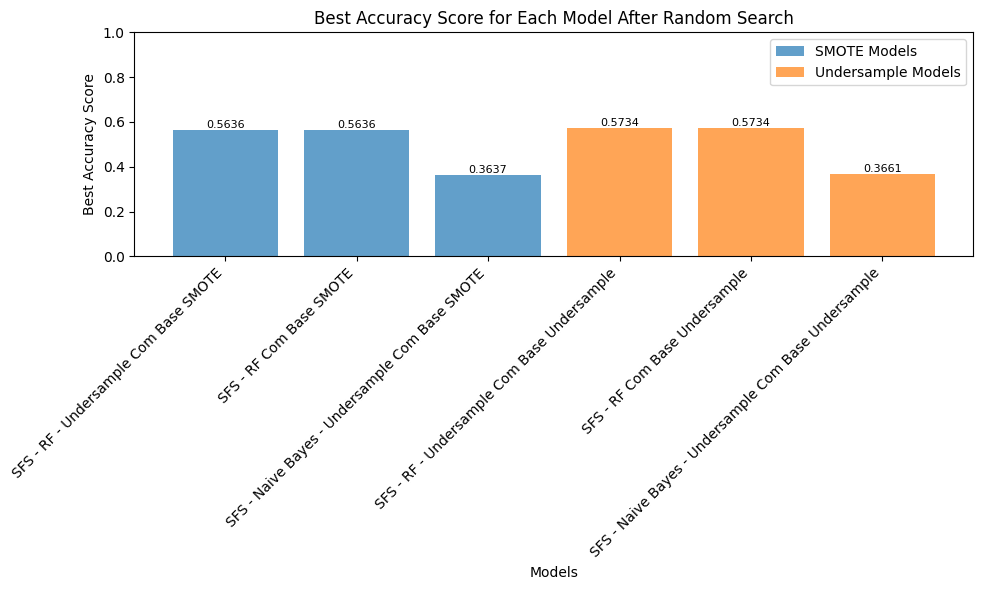

In [42]:
# Define the best scores for SMOTE and undersample models
all_best_scores = smote_best_scores + undersample_best_scores

# Combine and plot the results for SMOTE and undersample models
plt.figure(figsize=(10, 6))

# Plotting SMOTE results
x_pos_smote = np.arange(len(smote_model_names))
plt.bar(x_pos_smote, smote_best_scores, align='center', alpha=0.7, label='SMOTE Models')

# Plotting undersample results
x_pos_undersample = np.arange(len(undersample_model_names)) + len(smote_model_names)
plt.bar(x_pos_undersample, undersample_best_scores, align='center', alpha=0.7, label='Undersample Models')

# Combine x-axis labels
x_pos_combined = np.concatenate((x_pos_smote, x_pos_undersample))
all_model_names_combined = smote_model_names + undersample_model_names

# Set x-axis labels
plt.xticks(x_pos_combined, all_model_names_combined, rotation=45, ha='right')
plt.xlabel('Models')

# Set y-axis label
plt.ylabel('Best Accuracy Score')

# Set plot title
plt.title('Best Accuracy Score for Each Model After Random Search')

# Set y-axis limits
plt.ylim(0, 1)

# Add accuracy values on top of the bars
for i in range(len(all_model_names_combined)):
    plt.text(x=x_pos_combined[i], y=all_best_scores[i] + 0.01, s=f"{all_best_scores[i]:.4f}", ha='center', fontsize=8)

# Add legend
plt.legend()

plt.tight_layout()
plt.show()
